## 共有ドライブのマウント
- 参考：https://qiita.com/kikuchi_kentaro/items/65be0cf40ac61849d841

In [0]:
infile_name = "20190911_8genre_288video_text"

!pip install japanize_matplotlib
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# URLを開いて認証コードをコピーしボックスに貼り付けしてください
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!cp -f ~/.gdfuse/default/config config
!sed -i -e "s/^root_folder=$/root_folder=1Dm6GSlI06zTsmRg6KdpM2WBYU0wj-Umh/" config

!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive
!ls drive

     |████████████████████████████████| 4.1MB 108kB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.0.5-cp36-none-any.whl size=4118721 sha256=9318ee8b0948aee6b9bdaba365bfd8c6287045a96178f3df60cf6c638ead443b
  Stored in directory: /root/.cache/pip/wheels/6c/8a/08/4a784957da9f3c2b4839b4986be2fba2a481877318948be52c
Successfully built japanize-matplotlib
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 132684 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleuserc

In [0]:
import os
import csv
import pickle

import numpy as np
import pandas as pd

import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
sns.set(font='IPAexGothic')

from IPython.display import display, Image
import warnings
warnings.filterwarnings('ignore')
os.chdir("drive")
!ls

config	drive  dust  input  memo  midway  model  notebook  output


-----------

## CSVファイルのインポート

前回作成した'words','labels'csvファイルを読み込んでリストとして扱います。

In [0]:
#csvファイルをインポートして'labels'リストに格納
f = open(f"midway/{infile_name}_labels.csv", "r")
reader = csv.reader(f)
labels = [e for e in reader]
f.close()

#csvファイルをインポートして'words'リストに格納
f = open(f"midway/{infile_name}_words.csv", "r")
reader = csv.reader(f)
words = [e for e in reader]
f.close()

from itertools import chain
import collections
#'labels'リストの入れ子構造を解除
labels = list(chain.from_iterable(labels))
#'labels'リストをstr型からint型に変換
labels = [int(s) for s in labels]

## NLP class

In [0]:
import gensim
word_vecs = gensim.models.KeyedVectors.load_word2vec_format('model/model_fasttext_neo.vec', binary = False)

In [0]:
from keras.preprocessing.text import Tokenizer
import gensim
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re, time


# IDと単語の対応表作成（重要度可視化用）
from gensim import corpora
word_to_id = pd.DataFrame(corpora.Dictionary(words).token2id.items(), columns=['word', 'id'])
word_to_id = word_to_id[['id', 'word']]

class NLP:
  '''
    クラス変数
    word_vecs: fasttextをクラス変数として格納することでいちいちフェッチする手間を省いています

    インスタンス変数
    vector_type: "count", "binary", "tfidf", "w2v" が指定できますが "w2v"で問題ないと思います
    pred_model: 予測用のモデルです 今の所LGBM, RGBTが比較的高い精度を出します
    decomp_model: 次元圧縮モデルを指定します しないようにも設定(None)できます
                    単語ベクトルが負の成分を持つためw2vとNMFは併用できません
                    また、PCAを用いる際にはn_componentsが訓練データの次元の最小数以下になるように設定してください
                    今の所FactorAnalysis(n_components=30)がもっとも高い精度を出しています
    scdv: 入力された整数値の数だけクラスタを生成します scdvが大きいと計算にかなり時間がかかることに注意してください
    swem: Trueにするとscdvを無視して分散表現をmax poolingします
    word_vecs: クラス変数が未定義の場合、ここにfasttextを指定することで次からはクラス変数を参照するようになります
    add_feature: 文書の特徴量に、単語の文字種の割合(ひらがな含む、数字含む、熟語)、vector_typeに含まれる単語数の割合、平均単語長を追加します
                  多少精度が上がるような気がします
    random_state: 各種乱数のシード値を設定します
    display: pred_model評価時のグラフを表示するかを設定します
  '''
  
  word_vecs = None
  def __init__(self, vector_type, pred_model, decomp_model=None, scdv=1, swem=False, word_vecs=None, add_feature=True, 
               random_state=0, display=True):
    self.vector_type = vector_type
    self.pred_model = pred_model
    self.decomp_model = decomp_model
    self.scdv = int(scdv)
    self.swem = swem
    self.word_vecs = None
    self.ex_used_words = None
    self.words = None
    self.labels = None
    self.add_feature = add_feature
    self.random_state = random_state
    self.display = display
    if word_vecs != None:
      NLP.word_vecs = word_vecs

  def add_letter_len(self):
    word_len = []
    for i, doc in enumerate(self.words):
      cnt = 0
      for w in doc:
        cnt += len(w)
      word_len.append(cnt/len(doc))
    word_len = np.array(word_len).reshape(-1, 1)
    self.dr_ = np.hstack([self.dr_, word_len])

  def add_used_rate(self):
    used_rate = []
    for i, doc in enumerate(self.words):
      cnt = 0
      for w in doc:
        if w in self.ex_used_words:
          cnt += 1
      used_rate.append(cnt/len(doc))
    used_rate = np.array(used_rate).reshape(-1, 1)
    self.dr_ = np.hstack([self.dr_, used_rate])

  def add_letter_kinds(self):
    levels = np.unique(self.labels).shape[0]
    char_rate = []
    hira = re.compile('[ぁ-ゟ]+')
    digit = re.compile('[0-9]+')
    kanji = re.compile('[\u2E80-\u2FDF\u3005-\u3007\u3400-\u4DBF\u4E00-\u9FFF\uF900-\uFAFF\U00020000-\U0002EBEF]+')
    for doc in self.words:
      num_hira = 0
      num_digit = 0
      num_kanji = 0
      for w in doc:
        num_hira += int(hira.search(w)!=None)
        num_digit += int(digit.search(w)!=None)
        num_kanji += int(kanji.fullmatch(w)!=None)
      char_rate.append([num_hira/len(doc), num_digit/len(doc), num_kanji/len(doc)])    
    self.dr_ = np.hstack([self.dr_, np.array(char_rate)])

  def fit(self, words, labels):
    self.words = words
    self.labels = labels
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(self.words)
    if self.vector_type in ["count", "binary", "tfidf"]:
      self.dr_ = tokenizer.texts_to_matrix(self.words, self.vector_type)
    elif self.vector_type == "w2v":
      print("loading fasttext...")
      if NLP.word_vecs == None:
        NLP.word_vecs = gensim.models.KeyedVectors.load_word2vec_format('model/model_fasttext_neo.vec', binary = False)
      ex_words = set(NLP.word_vecs.index2word)
      used_words = set([w for doc in self.words for w in doc])
      self.ex_used_words = list(ex_words & used_words)
      if self.swem:
        self.dr_ = np.zeros((len(self.words), 300))
        for i, doc in enumerate(self.words):
            self.dr_[i, :] = self.get_doc_swem_max_vector(doc)
      else:
        self.dr_ = self.get_dr(self.get_word_cluster_vecs())
    return self

  def eval(self):
    print("making train, test sets...")
    self.make_train_test()
    self.pred_model.fit(self.X_train, self.y_train)
    print("modeling...")
    if self.display:
      self.eval_display()
    return self.score()

  def get_word_cluster_vecs(self):
    used_word_vectors = np.array([NLP.word_vecs[w] for w in self.ex_used_words])
    self.n_samples = len(self.words)
    self.word_vec_dim = 300 # 単語ベクトルの次元数
    print("fitting gmm...")
    gmm = mixture.GaussianMixture(n_components=self.scdv, covariance_type='tied', max_iter=50, random_state=self.random_state)
    gmm.fit(used_word_vectors)
    return gmm.predict_proba(used_word_vectors)

  def idf(self, word):
    df = np.sum(np.array([int(word in d) for d in self.words], dtype="float32"))
    return np.log((self.n_samples+1) / (df+1.0)) + 1

  def get_dr(self, word_probs):
    word_cluster_vectors = np.zeros(shape=(len(self.ex_used_words), self.scdv*self.word_vec_dim))
    for i, used_word in enumerate(self.ex_used_words):
      tmp = np.array([])
      for j in range(self.scdv):
        tmp = np.hstack([tmp, self.idf(used_word)*word_probs[i][j]*NLP.word_vecs[used_word]])
      word_cluster_vectors[i] = tmp
    doc_vectors = np.zeros(shape=(self.n_samples, self.scdv*self.word_vec_dim))
    cnts = np.zeros(len(self.words))
    for i, doc in enumerate(self.words):
      for w in doc:
        if not w in self.ex_used_words:
          continue
        doc_vectors[i] += word_cluster_vectors[self.ex_used_words.index(w)]
        cnts[i] += 1
    for i in range(len(self.words)):
      if np.linalg.norm(doc_vectors[i])==0:
        continue
      # doc_vectors[i] = doc_vectors[i]/np.linalg.norm(doc_vectors[i])
      doc_vectors[i] /= cnts[i]
    return doc_vectors

  def make_train_test(self):
    if self.add_feature:
      self.add_letter_kinds()
      self.add_letter_len()
      if self.ex_used_words != None:
        self.add_used_rate()
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.dr_, self.labels, test_size=0.25, random_state=self.random_state, stratify=self.labels)
    if self.decomp_model != None:
      self.decomp_model.fit(self.X_train)
      self.X_train = self.decomp_model.transform(self.X_train)
      self.X_test = self.decomp_model.transform(self.X_test)

  def eval_display(self):
    model_name = f"{infile_name}_model_{self.vector_type}"
    """学習、重要度可視化、モデルdump"""
    # 重要度の抽出
    feature_importances = pd.Series(self.pred_model.feature_importances_).sort_values(ascending=True)
    feature_importances = feature_importances.to_frame(name='重要度').sort_values(by='重要度', ascending=False)
    word2id = word_to_id.join(feature_importances)
    feature_importances = feature_importances.merge(word_to_id, how='inner', left_index=True, right_on=['id'])
    feature_importances = feature_importances.set_index('word')
    feature_importances = feature_importances.drop("id", axis=1)
    # TOP20可視化
    feature_importances[0:20].sort_values(by='重要度').plot.barh()
    plt.legend(loc='lower right')
    plt.title('重要度TOP20')
    path = f"model/{model_name}"
    if not os.path.exists(path):
      os.makedirs(path)
    plt.show()
    pickle.dump(self.pred_model, open(f"{path}/{model_name}.pkl", 'wb'))
    """モデルload、予測、精度確認"""
    # モデルload
    path = f"model/{model_name}"
    model = pickle.load(open(f"{path}/{model_name}.pkl", 'rb')) 
    print(model)
    print('---'*35)
    # 予測結果確認
    pred = model.predict(self.X_test)
    print('予測結果：', pred[0:5])
    print('---'*35)
    prob = model.predict_proba(self.X_test)
    print('予測確率：', prob[0:5])
    print('---'*35)
    # 精度確認
    target_names = list(set(self.labels))
    print(self.y_test)
    dict_cr = classification_report(np.hstack(self.y_test), np.hstack(pred), 
                                  target_names=target_names,
                                  output_dict=True)
    
  def score(self):
    train_score = self.pred_model.score(nlp.X_train, nlp.y_train)
    test_score = self.pred_model.score(nlp.X_test, nlp.y_test)
    # print('train acc.: {:.3}'.format(train_score))
    # print('test acc.: {:.3}'.format(test_score))
    return train_score, test_score

  def get_doc_swem_max_vector(self, doc):
    # https://nbviewer.jupyter.org/github/nekoumei/Comparison-DocClassification/blob/master/src/Classification_News.ipynb
      word_cnt = 0
      vector_size = 300
      doc_vector = np.zeros((len(doc), vector_size))
      for i, word in enumerate(doc):
          try:
              wv = NLP.word_vecs.wv[word]
          except KeyError:
              wv = np.zeros(vector_size)
          doc_vector[i, :] = wv
      doc_vector = np.max(doc_vector, axis=0)
      return doc_vector

In [0]:
# 数字が含まれる単語から数字を削除してみましたが、精度は若干下がるようです
trimmed_words = [[re.sub('[0-9]+',"", w) for w in doc if not w.isdigit()] for doc in words]

In [0]:
!pip install lightgbm
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis

pred_model = lgb.LGBMClassifier(random_state=0, n_estimators=100)
# pred_model = RandomForestClassifier(random_state=0, n_estimators=1000)
# pred_model = GradientBoostingClassifier(random_state=0, n_estimators=100, max_features="sqrt")
# FactorAnalysis(30) -> acc. 0.5791666 (avg. 10 times, non-trimmed) / 0.5722222 (avg. 10 times, trimmed)
# 

decomp_model = FactorAnalysis(n_components=30)
train_scores = []
test_scores = []
for rs in range(1):
  nlp = NLP("w2v", pred_model, word_vecs=word_vecs, swem=True, add_feature=True, 
            random_state=rs, display=False, decomp_model=decomp_model).fit(words, labels)
  t1, t2 = nlp.eval()
  train_scores.append(t1)
  test_scores.append(t2)

loading fasttext...
making train, test sets...
modeling...


In [0]:
np.mean(train_scores), np.mean(test_scores)

(1.0, 0.625)

In [0]:
y = np.array(nlp.labels)
cat_vecs = []
for cat in range(8):
  cat_vec = np.mean(nlp.dr_[y==cat], axis=0)
  cat_vec = cat_vec/np.linalg.norm(cat_vec)
  cat_vecs.append(cat_vec)
dot_heatmap = np.zeros((8, 8))
for i in range(8):
  for j in range(i+1):
    dot_heatmap[i][j] = dot_heatmap[j][i] = np.dot(cat_vecs[i], cat_vecs[j])

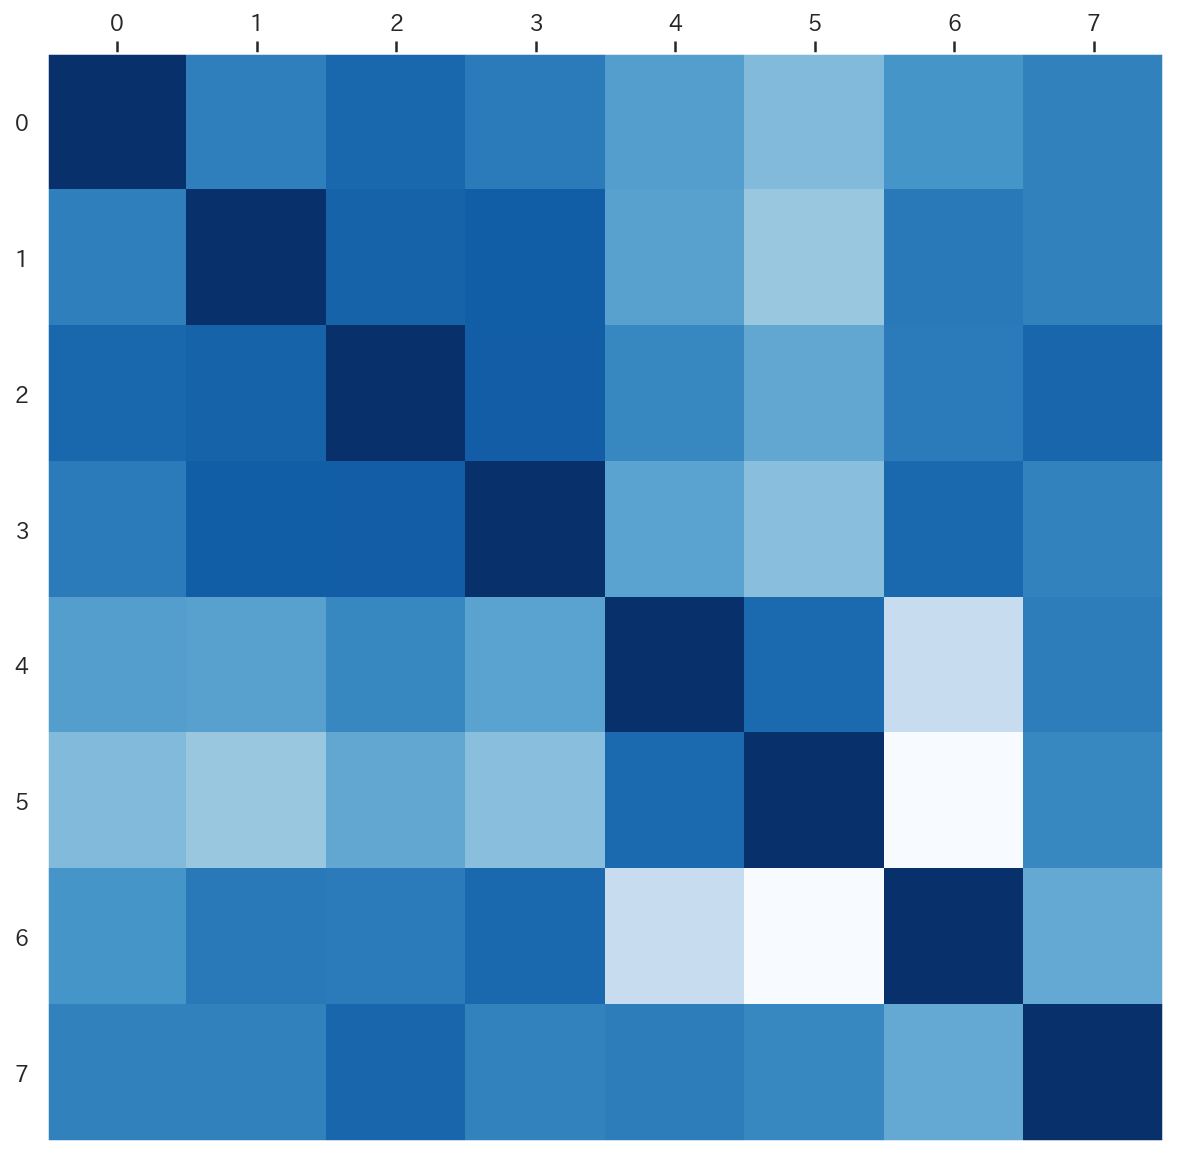

In [0]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
heatmap = ax.pcolor(dot_heatmap, cmap=plt.cm.Blues)

ax.set_xticks(np.arange(dot_heatmap.shape[0])+0.5)
ax.set_xticklabels(np.arange(dot_heatmap.shape[0]))
ax.set_yticks(np.arange(dot_heatmap.shape[1])+0.5)
ax.set_yticklabels(np.arange(dot_heatmap.shape[1]))

ax.invert_yaxis()

ax.xaxis.tick_top()
# ax.colorbar()
plt.show()

In [0]:
ex_words = set(NLP.word_vecs.index2word)
used_words = set([w for doc in words for w in doc])
ex_used_words = np.array(list(ex_words & used_words))

In [0]:
for cat in range(8):
  print(f'category {cat}')
  dots = []
  for w in ex_used_words:
    wv = NLP.word_vecs[w]
    dots.append(np.dot(cat_vecs[cat][:300],  wv / np.linalg.norm(wv)))
  dots = np.array(dots)
  for similar_word in ex_used_words[np.argsort(dots)[:10]]:
    print(similar_word, end=' ')
  print()

category 0
230 追いやら 遮ら 上部 155 127 構造物 ひとまとめ 140 集落 
category 1
230 集落 追いやら 高台 上部 155 ひとまとめ 遮ら 構造物 127 
category 2
230 追いやら 155 遮ら 集落 構造物 上部 127 ひとまとめ 高台 
category 3
230 上部 155 遮ら 構造物 集落 高台 127 140 120 
category 4
230 上部 遮ら 高台 155 集落 追いやら 構造物 127 140 
category 5
230 155 127 上部 構造物 140 高台 集落 遮ら 165 
category 6
230 追いやら 遮ら 155 集落 127 構造物 ひとまとめ 上部 120 
category 7
230 遮ら 155 追いやら 127 上部 集落 構造物 140 高台 


In [0]:
import collections
counters = []
y = np.array(labels)
all_counter = collections.Counter([w for doc in words for w in doc if w in ex_used_words])
distinct_cat_vecs = []
for i in range(8):
  print(f'category {i}')
  counter = collections.Counter([w for doc in np.array(words)[y==i] for w in doc if w in ex_used_words])
  distinct_cat_vec = np.zeros(300)
  cnt = 0
  for w in ex_used_words:
    if all_counter[w] == counter[w]:
      cnt += 1
      distinct_cat_vec += NLP.word_vecs[w]
  distinct_cat_vec /= np.linalg.norm(distinct_cat_vec)
  distinct_cat_vecs.append(distinct_cat_vec)

category 0
category 1
category 2
category 3
category 4
category 5
category 6
category 7


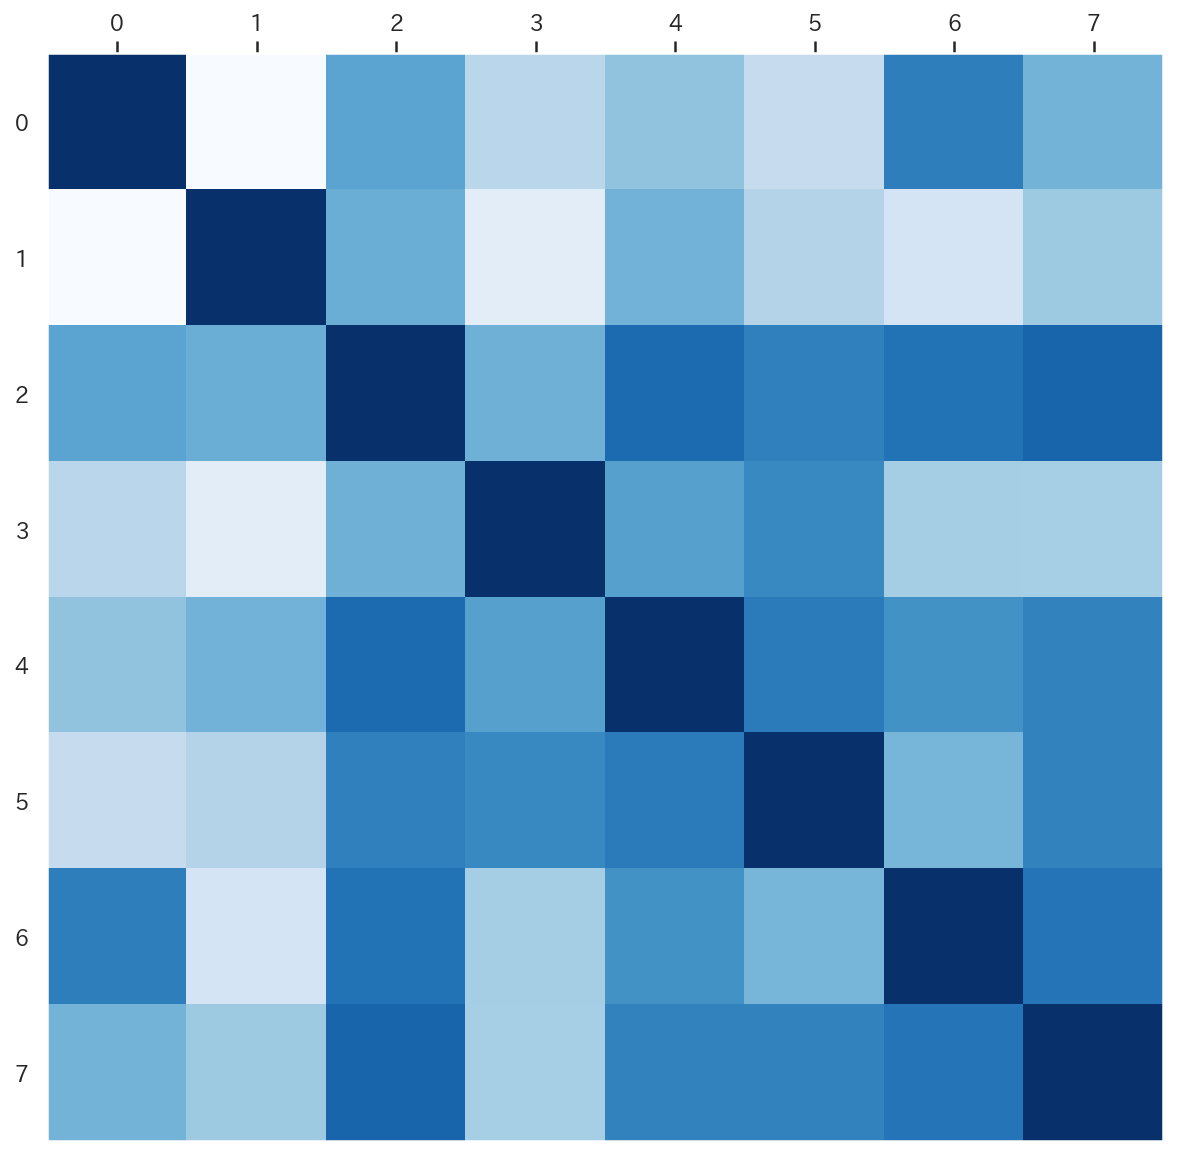

In [0]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
heatmap = ax.pcolor([[np.dot(distinct_cat_vecs[i], distinct_cat_vecs[j])for i in range(8)] for j in range(8)], cmap=plt.cm.Blues)

ax.set_xticks(np.arange(dot_heatmap.shape[0])+0.5)
ax.set_xticklabels(np.arange(dot_heatmap.shape[0]))
ax.set_yticks(np.arange(dot_heatmap.shape[1])+0.5)
ax.set_yticklabels(np.arange(dot_heatmap.shape[1]))

ax.invert_yaxis()

ax.xaxis.tick_top()
# ax.colorbar()
plt.show()